# Computing planar potential flows

In [ ]:
using ViscousFlow
using ImmersedLayers

┌ Info: Precompiling ImmersedLayers [cdc13194-334e-4e1c-bc8d-fc3a28509c85]
└ @ Base loading.jl:1278


In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

LoadError: InitError: PyError (PyImport_ImportModule

The Python package matplotlib could not be imported by pyimport. Usually this means
that you did not install matplotlib in the Python version being used by PyCall.

PyCall is currently configured to use the Python version at:

/usr/bin/python3

and you should use whatever mechanism you usually use (apt-get, pip, conda,
etcetera) to install the Python package containing the matplotlib module.

One alternative is to re-configure PyCall to use a different Python
version on your system: set ENV["PYTHON"] to the path/name of the python
executable you want to use, run Pkg.build("PyCall"), and re-launch Julia.

Another alternative is to configure PyCall to use a Julia-specific Python
distribution via the Conda.jl package (which installs a private Anaconda
Python distribution), which has the advantage that packages can be installed
and kept up-to-date via Julia.  As explained in the PyCall documentation,
set ENV["PYTHON"]="", run Pkg.build("PyCall"), and re-launch Julia. Then,
To install the matplotlib module, you can use `pyimport_conda("matplotlib", PKG)`,
where PKG is the Anaconda package the contains the module matplotlib,
or alternatively you can use the Conda package directly (via
`using Conda` followed by `Conda.add` etcetera).

) <class 'ImportError'>
ImportError('\n\nIMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!\n\nImporting the numpy c-extensions failed.\n- Try uninstalling and reinstalling numpy.\n- If you have already done that, then:\n  1. Check that you expected to use Python3.7 from "/usr/bin/python3",\n     and that you have no directories in your PATH or PYTHONPATH that can\n     interfere with the Python and numpy version "1.17.4" you\'re trying to use.\n  2. If (1) looks fine, you can open a new issue at\n     https://github.com/numpy/numpy/issues.  Please include details on:\n     - how you installed Python\n     - how you installed numpy\n     - your operating system\n     - whether or not you have multiple versions of Python installed\n     - if you built from source, your compiler versions and ideally a build log\n\n- If you\'re working with a numpy git repository, try `git clean -xdf`\n  (removes all files not under version control) and rebuild numpy.\n\nNote: this error has many possible causes, so please don\'t comment on\nan existing issue about this - open a new one instead.\n\nOriginal error was: No module named \'numpy.core._multiarray_umath\'\n')
  File "/usr/lib/python3/dist-packages/matplotlib/__init__.py", line 138, in <module>
    from . import cbook, rcsetup
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 31, in <module>
    import numpy as np
  File "/usr/lib/python3/dist-packages/numpy/__init__.py", line 142, in <module>
    from . import core
  File "/usr/lib/python3/dist-packages/numpy/core/__init__.py", line 47, in <module>
    raise ImportError(msg)

during initialization of module PyPlot

In [3]:
using LinearAlgebra

### First, some generalities

In [4]:
Δx = 0.02
xlim = (-3,3)
ylim = (-3,3)
g = PhysicalGrid(xlim,ylim,Δx)

w = Nodes(Dual,size(g))
L = plan_laplacian(size(w),with_inverse=true)

xg,yg = coordinates(w,g);

## Flat plate

In [5]:
n = 50
body = Plate(1.0,n)
ds = 1.0/n

xc = 0.0; yc = 0.0
T = RigidTransform((xc,yc),-π/3)
T(body)

Plate with 50 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): -1.0471975511965976


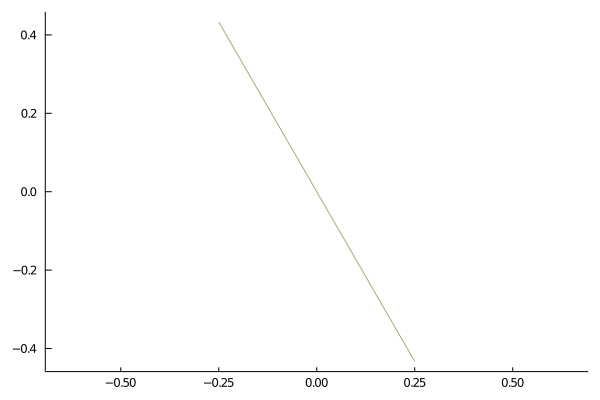

In [6]:
plot(body)

In [7]:
X = VectorData(0.5*(body.x[1:end-1]+body.x[2:end]),0.5*(body.y[1:end-1]+body.y[2:end]))
s = 0.5*(body.x̃[1:end-1]+body.x̃[2:end]);

f = ScalarData(X);

In [8]:
θ = acos.(2*body.x̃);

In [9]:
println("Ratio of arc spacing to cell size = ",ds/Δx)

Ratio of arc spacing to cell size = 1.0


In [100]:
regop = Regularize(X,Δx,I0=origin(g),weights=ds,ddftype=CartesianGrids.Yang3)

Regularization/interpolation operator with non-filtered interpolation
  DDF type CartesianGrids.Yang3
  314 points in grid with cell area 0.0004


In [102]:
Rmat = RegularizationMatrix(regop,f,w);
Emat = InterpolationMatrix(regop,w,f);

In [103]:
ψb = ScalarData(X)
rhs = SaddleVector(w,ψb)

(Dual nodes in a (nx = 308, ny = 308) cell grid of type Float64 data
  Number of Dual nodes: (nx = 308, ny = 308), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [104]:
PS = SaddleSystem(L,Emat,Rmat,rhs)

Saddle system with 94864 states and 314 constraints and
   State vector of type Nodes{Dual,308,308,Float64,Array{Float64,2}}
   Constraint vector of type ScalarData{314,Float64,Array{Float64,1}}
   Elements of type Float64
using a Direct solver


In [105]:
#Θ = diagm(1.0./sqrt.(1/4 .- s.^2));
#Θ = diagm(diff(θ)./ds);

ψb .= 1.0
@time sol = PS\rhs

f0 = constraint(sol)
Θ = diagm(f0);

  0.548969 seconds (1.80 M allocations: 95.842 MiB, 2.39% gc time)


In [106]:
R̃mat = deepcopy(Rmat);
R̃mat.M .= R̃mat.M*Θ;
Ẽmat = deepcopy(Emat);

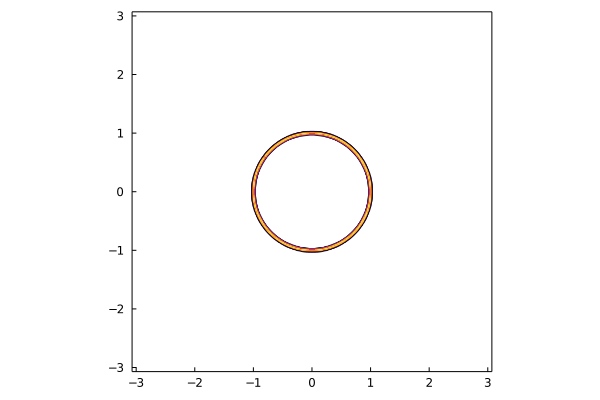

In [107]:
f .= 1;
plot(xg,yg,Rmat*f)

In [108]:
PS̃ = SaddleSystem(L,Emat,R̃mat,rhs)

Saddle system with 94864 states and 314 constraints and
   State vector of type Nodes{Dual,308,308,Float64,Array{Float64,2}}
   Constraint vector of type ScalarData{314,Float64,Array{Float64,1}}
   Elements of type Float64
using a Direct solver


In [109]:
ψ = Nodes(Dual,w)
ψtot = zero(ψ);

In [110]:
U∞ = 1.0
ψb .= -U∞*(X.v .- body.cent[2]) # Translation in x direction
#ψb .= 1.0

#ψ̃b.data .= Θ*ψ̃b.data;

@time sol = PS\rhs
ψ,f = state(sol), constraint(sol)

ψ̃b = deepcopy(ψb);
r̃hs = SaddleVector(w,ψ̃b)
@time s̃ol = PS̃\r̃hs

ψ,f̃ = state(s̃ol), constraint(s̃ol)

ψtot .= ψ .+ yg' .- body.cent[2]; # adding the free-stream streamfunction

  0.008757 seconds (78 allocations: 7.250 MiB)
  0.011720 seconds (78 allocations: 7.250 MiB)


In [118]:
S = Matrix(PS.S)
S̃ = Matrix(PS̃.S);

In [119]:
F = svd(S);
F̃ = svd(S̃);

In [120]:
θ = acos.(2*s)
j = 6
plot(θ,F̃.U[:,j])
#plot!(θ,F.U[:,j])

LoadError: Expects 49 elements in each col of y, found 314.

### Circles

#### Now create a circular shape, with discrete points and associated regularization and interpolation operator

In [121]:
n = 150

R = 1.0
body = Circle(R,n)

# Find the minimum arc length
ds = minimum(dlength(body))

# Move the circle
xc = 0.0; yc = 0.0
T = RigidTransform((xc,yc),0.0)
T(body)

Circular body with 150 points and radius 1.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


#### Set up the coordinates and other useful vectors

In [122]:
X = VectorData(body.x,body.y)
f = ScalarData(X);
ψb = ScalarData(X);

In [123]:
println("Ratio of arc spacing to cell size = ",ds/Δx)

Ratio of arc spacing to cell size = 2.094241988335652


In [125]:
regop = Regularize(X,Δx,I0=origin(g),issymmetric=true,ddftype=CartesianGrids.Yang3)

Symmetric regularization/interpolation operator with non-filtered interpolation
  DDF type CartesianGrids.Yang3
  150 points in grid with cell area 0.0004


In [126]:
Rmat,Emat = RegularizationMatrix(regop,f,w);

#### And now create the saddle-point system

In [127]:
rhs = SaddleVector(w,ψb)
PS = SaddleSystem(L,Emat,Rmat,rhs)

Saddle system with 94864 states and 150 constraints and
   State vector of type Nodes{Dual,308,308,Float64,Array{Float64,2}}
   Constraint vector of type ScalarData{150,Float64,Array{Float64,1}}
   Elements of type Float64
using a Direct solver


#### Create some data structures for general use

In [128]:
w = Nodes(Dual,size(g))
ψ = Nodes(Dual,w);

### Solve flow generated by a translating cylinder

In [129]:
ψb .= -(body.x .- body.cent[1])
@time sol = PS\rhs
ψ,f = state(sol), constraint(sol);

  0.332307 seconds (571.63 k allocations: 36.148 MiB)


#### Plot the result

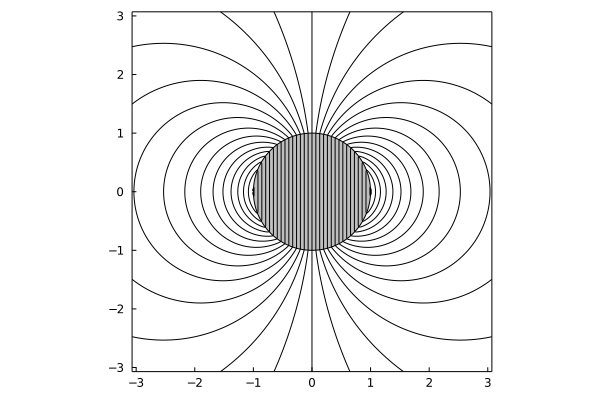

In [130]:
xg,yg = coordinates(ψ,g)
plot(xg,yg,ψ,linecolor=:black,levels=range(-1,1,length=31))
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

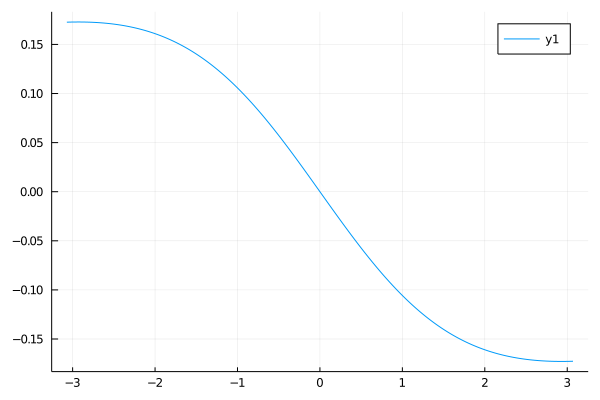

In [131]:
plot(xg,ψ[:,301])

Plot the result in a frame in which cylinder is stationary

In [132]:
ψtot = Nodes(Dual,ψ)
ψtot .= ψ .+ xg .- body.cent[1]; # adding the free-stream streamfunction

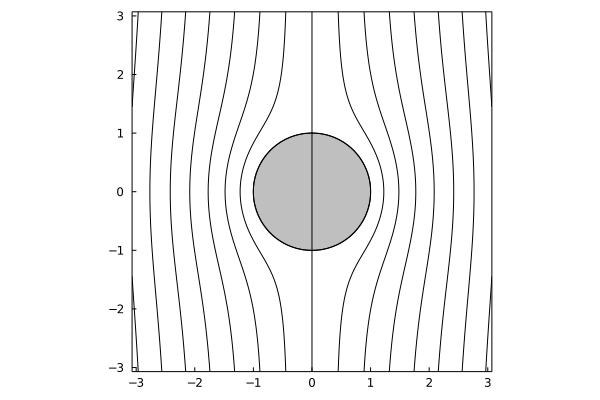

In [133]:
xg,yg = coordinates(ψ,g)
plot(xg,yg,ψtot,linecolor=:black,levels=range(-6,6,length=31))
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

Compare the generated vortex sheet `f/ds` with the exact solution

In [134]:
θ = range(0,2π,length=n+1)
fex = -2*cos.(θ[1:n]);
errinf = LinearAlgebra.norm(f./ds-fex,Inf)

0.0412019560411534

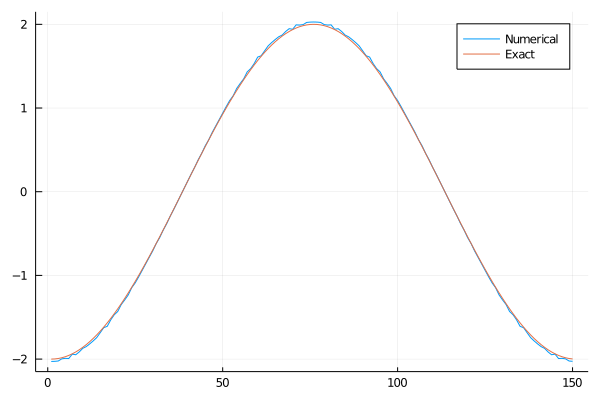

In [135]:
plot(f./ds,label="Numerical")
plot!(fex,label="Exact")

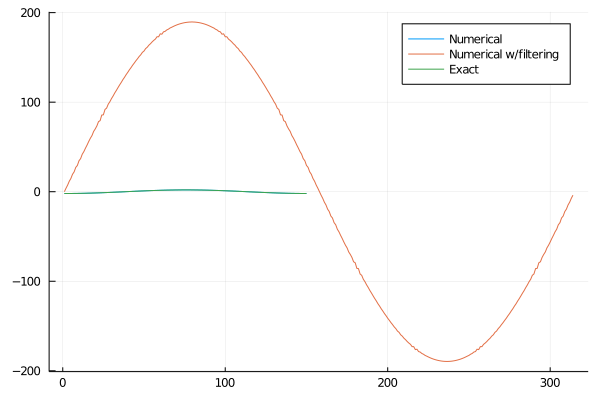

In [136]:
plot(f./ds,label="Numerical")
plot!(f̃./ds,label="Numerical w/filtering")
plot!(fex,label="Exact")

### Now try using a double-layer potential to set the interior solution

In [140]:
dlayer = ImmersedLayers.DoubleLayer(body,regop,ψ)

LoadError: UndefVarError: ImmersedLayers not defined

In [138]:
ψb .= -(body.x .- body.cent[1])
rhs = SaddleVector(w - dlayer(ψb),0.5*ψb)
@time sol = PS\rhs
ψd,fd = state(sol), constraint(sol)

LoadError: UndefVarError: dlayer not defined

In [40]:
plot(xg,ψd[:,151])
plot!(xg,ψ[:,151])

LoadError: UndefVarError: ψd not defined

In [41]:
xg,yg = coordinates(ψ,g)
plot(xg,yg,ψd,linecolor=:black,levels=range(-1,1,length=31))
#plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

LoadError: UndefVarError: ψd not defined

In [42]:
plot(2fd./ds,label="Numerical")
plot!(fex,label="Exact")

LoadError: MethodError: no method matching *(::Int64, ::typeof(fd))
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:538
  *(!Matched::PyCall.PyObject, ::Any) at /home/sinan/.julia/packages/PyCall/BcTLp/src/pyoperators.jl:13
  *(!Matched::ConstrainedSystems.IFOperator, ::Any) at /home/sinan/.julia/packages/ConstrainedSystems/pgefJ/src/timemarching/ifherk.jl:166
  ...

### Now flow about a cylinder with net circulation

#### Set up some helpful operators

`oB` is the basis vector for uniform Lagrange point data. As a transpose, it is a summation operator on Lagrange point data.

In [43]:
oB = zeros(size(f))
oB .= 1;

`S` is a matrix form of the Schur complement,

$$S = -EL^{-1}H$$

In [44]:
S = Matrix(PS.S);

LoadError: UndefVarError: PS not defined

`T` is a modified version of the Schur complement. Note that the operator

$$S^{-1}T S^{-1} = S^{-1}\left(S - \frac{o_B^T o_B}{o_B^T S^{-1} o_B} \right) S^{-1}$$

is identically zero when it acts upon uniform Lagrange point data. It produces the influence of the variable part of Lagrange point data on the vortex sheet strength.

In [45]:
S₀ = transpose(oB)*(S\oB)
T = S - oB*transpose(oB)/S₀;

LoadError: UndefVarError: S not defined

#### Now set the problem parameters

In [46]:
# The desired streamfunction on the circle surface
ψb .= 1

# The desired circulation about the circle
Γ0 = 1;

#### Compute the vortex sheet strength

As mentioned above, the first term is actually zero when $\psi_b$ is uniform. So this sheet strength is entirely due to the desired circulation, distributed uniformly on the surface.

In [47]:
f .= S\(T*(S\ψb) .+ Γ0*oB/S₀);

LoadError: UndefVarError: S not defined

#### Check that this `f` gives correct circulation

In [48]:
sum(f)

0.0

#### Now the streamfunction

Here, we compute the uniform streamfunction. We first cancel the circulation due to the vortex sheet (attributable to the desired circulation), and then we add the desired streamfunction on the circle.

In [49]:
ψ₀ = -1/S₀*(Γ0 - transpose(oB)*(S\ψb))

LoadError: UndefVarError: S₀ not defined

The overall streamfunction is due to the field induced by the vortex sheet and to the uniform value. 

In [50]:
ψ .= -(L\(Rmat*f)) .+ ψ₀;

LoadError: UndefVarError: Rmat not defined

In [51]:
q = curl(ψ)/Δx;

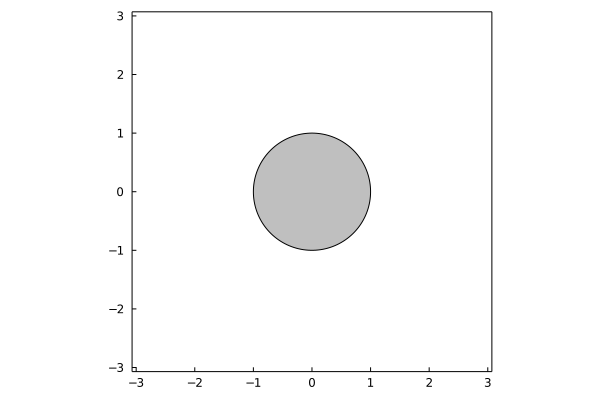

In [52]:
xg,yg = coordinates(ψ,g)
plot(xg,yg,ψ,linecolor=:black)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

#### Plot the vertical velocity along a horizontal line

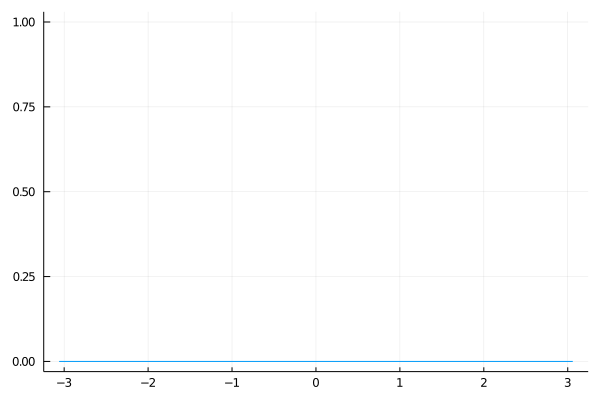

In [53]:
jcent = size(g,2) ÷ 2
xu,yu = coordinates(q.v,g)
plot(xu,q.v[:,jcent],legend=:false)

#### Plot the streamfunction along a horizontal line

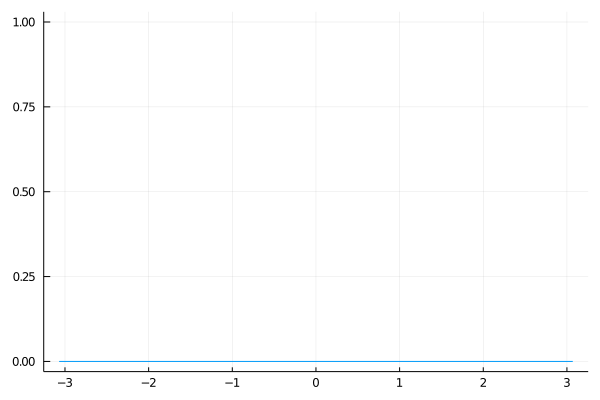

In [54]:
jcent = size(g,2) ÷ 2
plot(xg,ψ[:,jcent],legend=:false)

### Now flow about another shape with net circulation

In [55]:
#body = Rectangle(1.0,1.0,100)
body = Circle(1.0,300)
#body = Plate(1.0,50)

# Find the minimum arc length
ds = minimum(Bodies.dlength(body))

# Move the shape
xc = 0.5; yc = 0.0; α = π/3
T = RigidTransform((xc,yc),-α)
T(body)

normb = normalmid(body)
dsb = dlengthmid(body);

LoadError: UndefVarError: Bodies not defined

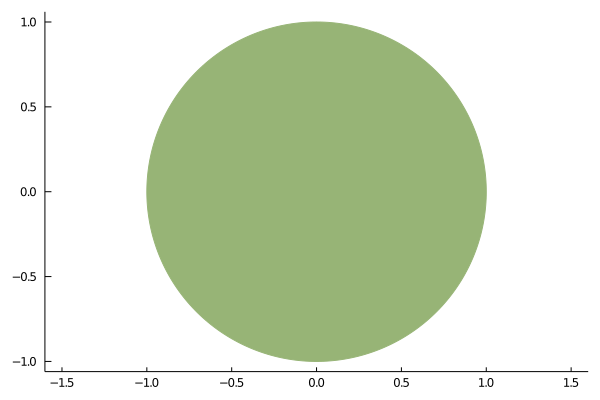

In [56]:
plot(body)

In [57]:
transpose(body.y)*(normb[2].*dsb)

LoadError: UndefVarError: normb not defined

In [58]:
X = VectorData(body.x,body.y)
f = ScalarData(X);
ψb = ScalarData(X);

In [59]:
println("Ratio of arc spacing to cell size = ",ds/Δx)

Ratio of arc spacing to cell size = 1.0


In [60]:
regop = Regularize(X,Δx,I0=origin(g),issymmetric=true,ddftype=Fields.Yang3)
Rmat,Emat = RegularizationMatrix(regop,f,w);

LoadError: UndefVarError: Fields not defined

#### And now create the saddle-point system

In [61]:
rhs = SaddleVector(w,ψb)
PS = SaddleSystem(L,Emat,Rmat,rhs)

LoadError: UndefVarError: Emat not defined

In [62]:
S = Matrix(PS.S);

LoadError: UndefVarError: PS not defined

#### Create some data structures for general use

In [63]:
w = Nodes(Dual,size(g));
ψ = Nodes(Dual,w)
f = ScalarData(X);

In [64]:
oB = zeros(size(f))
oB .= 1;

`S` is a matrix form of the Schur complement,

$$S = -EL^{-1}H$$

`T` is a modified version of the Schur complement. Note that the operator

$$S^{-1}T S^{-1} = S^{-1}\left(S - \frac{o_B^T o_B}{o_B^T S^{-1} o_B} \right) S^{-1}$$

is identically zero when it acts upon uniform Lagrange point data. It produces the influence of the variable part of Lagrange point data on the vortex sheet strength.

In [65]:
Γ₀ = transpose(oB)*(S\oB)
T = S - oB*transpose(oB)/Γ₀;
PC = I - oB*transpose(oB)*inv(S)/Γ₀;
k = 50 #298
eK = zeros(size(f))
eK[k] = 1.0;
#eK[k-1] = 0.25; eK[k] = 0.5; eK[k+1] = 0.25;
PK = I - oB*transpose(eK);

LoadError: UndefVarError: S not defined

In [66]:
f0 = ScalarData(X);
f0 .= S\oB;

LoadError: UndefVarError: S not defined

Normalize f0 to have circulation equal to 1,

$$ f_0 = \dfrac{S^{-1}o_B}{o_B^T S^{-1}o_B} $$

In [67]:
ψ .= -(L\(Rmat*f0)); #.+ transpose(yg .- body.cent[2])
xg,yg = coordinates(ψ,g)
plot(xg,yg,ψ,linecolor=:black,levels=31)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

LoadError: UndefVarError: Rmat not defined

In [68]:
S̃ = S*Diagonal(f0);

LoadError: UndefVarError: S not defined

#### Now set the problem parameters

In [69]:
# The desired streamfunction on the circle surface
#ψb .= -(body.x .- body.cent[1]); # Translation in y direction
ψb .= -(body.y .- body.cent[2]); # Translation in -x direction
#ψb .= -0.5*((body.x .- body.cent[1]).^2+(body.y .- body.cent[2]).^2); # Rotation about centroid
ψb .= PC*ψb; # project out the circulation

# The desired circulation about the body
#Γ0 = 0;

LoadError: UndefVarError: PC not defined

In [70]:
transpose(oB)*(S\ψb)

LoadError: UndefVarError: S not defined

#### Compute the vortex sheet strength

As mentioned above, the first term is actually zero when $\psi_b$ is uniform. So this sheet strength is entirely due to the desired circulation, distributed uniformly on the surface.

In [71]:
f̃ = ScalarData(X);
#f .= S\(T*(S\ψb) .+ Γ0*oB/S₀);
f̃ .= S̃\ψb;
#f̃ .= PK*(S̃\ψb);
#f̃ .= S̃\ψb;

f = f0∘f̃;

LoadError: UndefVarError: S̃ not defined

#### Check that this `f` gives correct circulation

In [72]:
sum(f)

0.0

#### Now the streamfunction

Here, we compute the uniform streamfunction. We first cancel the circulation due to the vortex sheet (attributable to the desired circulation), and then we add the desired streamfunction on the circle.

In [73]:
#ψ₀ = -1/S₀*(Γ0 - transpose(oB)*(S\ψb))

The overall streamfunction is due to the field induced by the vortex sheet and to the uniform value. 

In [74]:
ψ .= -(L\(Rmat*f)) .+ transpose(yg .- body.cent[2])  #.+ ψ₀;

LoadError: UndefVarError: Rmat not defined

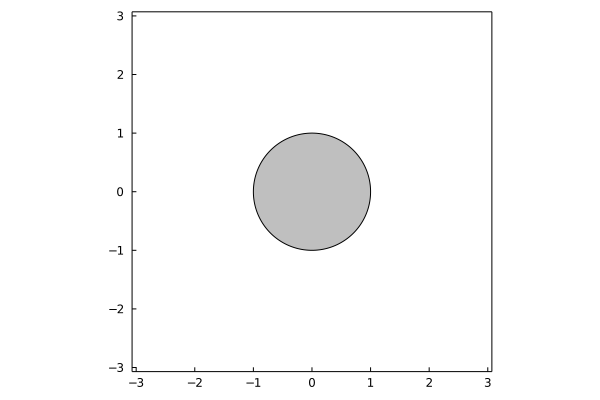

In [75]:
xg,yg = coordinates(ψ,g)
plot(xg,yg,ψ,linecolor=:black,levels=31)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

### Let's try an airfoil

In [76]:
?NACA4

search: NACA4 plan_laplacian plan_laplacian!



In [77]:
c = 1.0
body = NACA4(0.0,0.0,0.12,np=50,len=c)

#body = Plate(1.0,26)
ds = minimum(Bodies.dlength(body));


# Find the minimum arc length
#ds = maximum(Bodies.dlength(body))

# Move the shape
xc = 1.0; yc = 1.0
α = 20π/180
T = RigidTransform((xc,yc),-α)
T(body)

LoadError: StackOverflowError:

In [78]:
Xraw = zeros(length(body.x),2)
Xraw[:,1] .= body.x
Xraw[:,2] .= body.y
body = SplinedBody(Xraw,Δx)
ds = maximum(Bodies.dlength(body))

LoadError: UndefVarError: Bodies not defined

In [79]:
X = VectorData(body.x,body.y)
f = ScalarData(X);
ψb = ScalarData(X);

In [80]:
println("Ratio of arc spacing to cell size = ",ds/Δx)

Ratio of arc spacing to cell size = 1.0


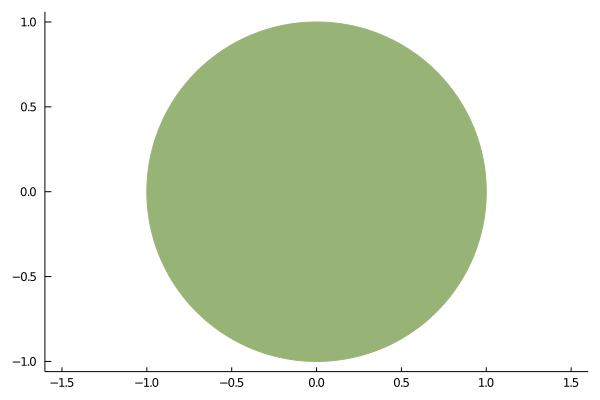

In [81]:
plot(body)

In [82]:
regop = Regularize(X,Δx,I0=origin(g),issymmetric=true,ddftype=Fields.Yang3)
Rmat,Emat = RegularizationMatrix(regop,f,w);

LoadError: UndefVarError: Fields not defined

#### And now create the saddle-point system

In [83]:
rhs = SaddleVector(w,ψb)
PS = SaddleSystem(L,Emat,Rmat,rhs)

LoadError: UndefVarError: Emat not defined

#### Create some data structures for general use

In [84]:
w = Nodes(Dual,size(g));
ψ = Nodes(Dual,w)
f = ScalarData(X);

In [85]:
oB = zeros(size(f))
oB .= 1;

In [86]:
τ = zeros(size(f))
τ[end] = 1
#τ[2] = 1/2
#τ[end] = 1/2;

`S` is a matrix form of the Schur complement,

$$S = -EL^{-1}H$$

In [87]:
S = Matrix(PS.S);

LoadError: UndefVarError: PS not defined

`T` is a modified version of the Schur complement. Note that the operator

$$S^{-1}T S^{-1} = S^{-1}\left(S - \frac{o_B^T o_B}{o_B^T S^{-1} o_B} \right) S^{-1}$$

is identically zero when it acts upon uniform Lagrange point data. It produces the influence of the variable part of Lagrange point data on the vortex sheet strength.

In [88]:
#S₀ = transpose(oB)*(S\oB)
#T = S - oB*transpose(oB)/S₀;
S₀ = transpose(τ)*(S\τ)
T = S - τ*transpose(τ)/S₀;

LoadError: UndefVarError: S not defined

#### Now set the problem parameters

In [89]:
# free stream
U∞ = 1

# The desired streamfunction on the circle surface
ψb .= -U∞*(body.y .- body.cent[2]) # Translation in x direction

# The desired circulation about the circle
Γ0 = -π*c*U∞*sin(α)

γs = 0;

LoadError: UndefVarError: α not defined

#### Compute the vortex sheet strength

As mentioned above, the first term is actually zero when $\psi_b$ is uniform. So this sheet strength is entirely due to the desired circulation, distributed uniformly on the surface.

In [90]:
#f .= S\(T*(S\ψb) .+ Γ0*oB/S₀);
f .= S\(T*(S\ψb) .+ ds*γs*τ/S₀);

LoadError: UndefVarError: S not defined

In [91]:
f[end]

0.0

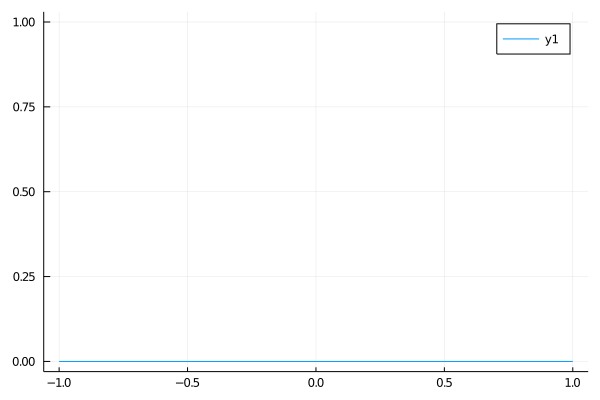

In [92]:
plot(X.u,f./ds)

#### Now the streamfunction

Here, we compute the uniform streamfunction. We first cancel the circulation due to the vortex sheet (attributable to the desired circulation), and then we add the desired streamfunction on the circle.

In [93]:
#ψ₀ = -1/S₀*(Γ0 - transpose(oB)*(S\ψb))
ψ₀ = -1/S₀*(ds*γs - transpose(τ)*(S\ψb))

LoadError: UndefVarError: S₀ not defined

The overall streamfunction is due to the field induced by the vortex sheet and to the uniform value. 

In [94]:
ψ .= -(L\(Rmat*f)) .+ ψ₀;

LoadError: UndefVarError: Rmat not defined

In [95]:
xg, yg = coordinates(ψ,g)
ψtot = Nodes(Dual,ψ)
ψtot .= ψ .+ yg' .- body.cent[2]; # adding the free-stream streamfunction

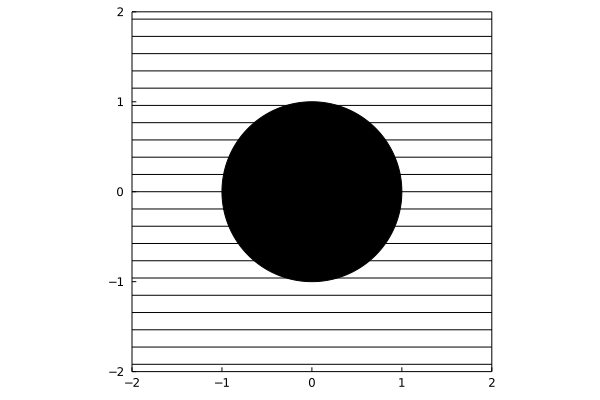

In [96]:
plot(xg,yg,ψtot,linecolor=:black,levels=31)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=1,linecolor=:black,xlim=(-2,2),ylim=(-2,2))